In [2]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [10]:
def plot_path(cart_path,target):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


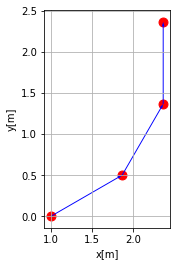

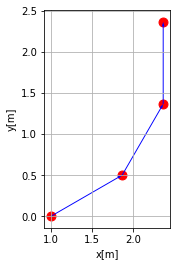

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes)

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_V_STEP = 0.5 / DATA_HZ # [m/step]
DATA_MAX_V_STEP = 1.0 / DATA_HZ # [m/step]
DATA_W_STEP = xp.pi * 0.5 / DATA_HZ # [rad/step]
DATA_MAX_W_STEP = xp.pi * 0.5 / DATA_HZ # [rad/step]
DATA_RANGE_TRANSLATE = 0 # 経路を直進方向にずらす
DATA_RANGE_ROTATE = 0 # 経路を回転方向にずらす

params = []
params.append('DATA_SIZE            :'+str(DATA_SIZE))
params.append('DATA_NUM_WAYPOINTS   :'+str(DATA_NUM_WAYPOINTS))
params.append('DATA_NUM_STEP        :'+str(DATA_NUM_STEP))
params.append('DATA_V_STEP          :'+str(DATA_V_STEP))
params.append('DATA_MAX_V_STEP      :'+str(DATA_MAX_V_STEP))
params.append('DATA_W_STEP          :'+str(DATA_W_STEP))
params.append('DATA_MAX_W_STEP      :'+str(DATA_MAX_W_STEP))
params.append('DATA_RANGE_TRANSLATE :'+str(DATA_RANGE_TRANSLATE))
params.append('DATA_RANGE_ROTATE    :'+str(DATA_RANGE_ROTATE))
for a in params:
    print(a)

DATA_SIZE            :1000
DATA_NUM_WAYPOINTS   :10
DATA_NUM_STEP        :10
DATA_V_STEP          :0.05
DATA_MAX_V_STEP      :0.1
DATA_W_STEP          :0.15707963267948966
DATA_MAX_W_STEP      :0.15707963267948966
DATA_RANGE_TRANSLATE :0
DATA_RANGE_ROTATE    :0


In [6]:
X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    X_train.append(d)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

1000
(10, 3)


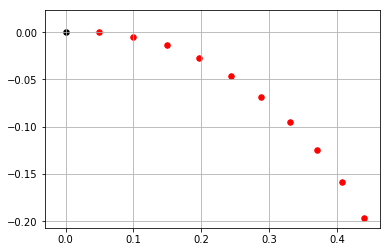

 -- x_train -- 
[[ 4.99819987e-02  1.18480711e-07 -1.71023870e+00]
 [ 9.97482026e-02 -4.63940112e-03 -1.80319870e+00]
 [ 1.48868864e-01 -1.38784950e-02 -1.89615870e+00]
 [ 1.96919808e-01 -2.76373804e-02 -1.98911870e+00]
 [ 2.43486100e-01 -4.57972446e-02 -2.08207870e+00]
 [ 2.88165623e-01 -6.82012711e-02 -2.17503870e+00]
 [ 3.30572555e-01 -9.46559935e-02 -2.26799870e+00]
 [ 3.70340697e-01 -1.24932966e-01 -2.36095870e+00]
 [ 4.07126637e-01 -1.58770737e-01 -2.45391870e+00]
 [ 4.40612718e-01 -1.95877106e-01 -2.54687870e+00]]


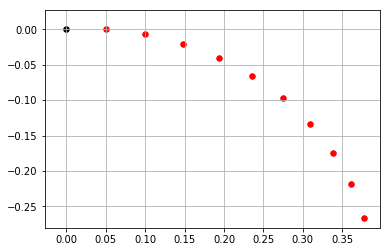

 -- x_train -- 
[[ 4.99613679e-02  2.23290987e-07 -1.77508580e+00]
 [ 9.94601472e-02 -6.78277983e-03 -1.91127580e+00]
 [ 1.47579667e-01 -2.02233945e-02 -2.04746580e+00]
 [ 1.93428798e-01 -4.00727130e-02 -2.18365580e+00]
 [ 2.36158458e-01 -6.59631446e-02 -2.31984580e+00]
 [ 2.74977333e-01 -9.74152227e-02 -2.45603580e+00]
 [ 3.09166534e-01 -1.33846484e-01 -2.59222580e+00]
 [ 3.38092909e-01 -1.74582256e-01 -2.72841580e+00]
 [ 3.61220768e-01 -2.18868150e-01 -2.86460580e+00]
 [ 3.78121806e-01 -2.65884033e-01 -3.00079580e+00]]


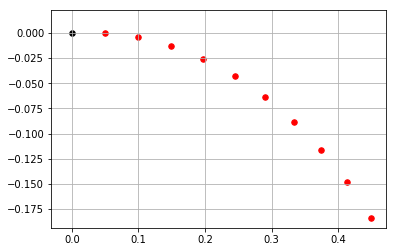

 -- x_train -- 
[[ 4.99844818e-02  9.55041798e-09 -1.70026152e+00]
 [ 9.97829024e-02 -4.30878723e-03 -1.78657152e+00]
 [ 1.49024523e-01 -1.28943122e-02 -1.87288152e+00]
 [ 1.97342750e-01 -2.56926480e-02 -1.95919152e+00]
 [ 2.44377863e-01 -4.26085136e-02 -2.04550152e+00]
 [ 2.89779697e-01 -6.35159739e-02 -2.13181152e+00]
 [ 3.33210244e-01 -8.82593772e-02 -2.21812152e+00]
 [ 3.74346173e-01 -1.16654514e-01 -2.30443152e+00]
 [ 4.12881235e-01 -1.48489988e-01 -2.39074152e+00]
 [ 4.48528544e-01 -1.83528792e-01 -2.47705152e+00]]


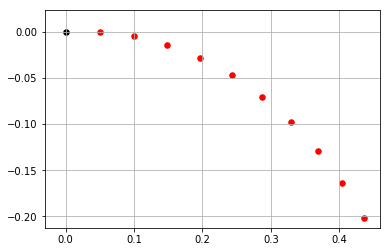

 -- x_train -- 
[[ 4.99808022e-02  1.95779730e-07 -1.71480024e+00]
 [ 9.97314885e-02 -4.79039978e-03 -1.81080024e+00]
 [ 1.48793908e-01 -1.43276704e-02 -1.90680024e+00]
 [ 1.96716250e-01 -2.85237882e-02 -2.00280024e+00]
 [ 2.43057200e-01 -4.72480221e-02 -2.09880024e+00]
 [ 2.87390008e-01 -7.03279421e-02 -2.19480024e+00]
 [ 3.29306417e-01 -9.75510069e-02 -2.29080024e+00]
 [ 3.68420422e-01 -1.28666521e-01 -2.38680024e+00]
 [ 4.04371824e-01 -1.63387945e-01 -2.48280024e+00]
 [ 4.36829550e-01 -2.01395531e-01 -2.57880024e+00]]


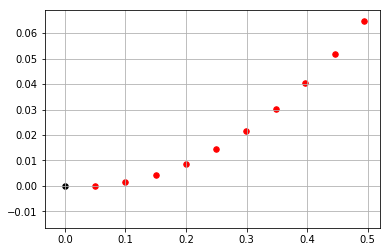

 -- x_train -- 
[[ 4.99982540e-02 -1.49654769e-07 -1.52736833e+00]
 [ 9.99755619e-02  1.44694803e-03 -1.49841833e+00]
 [ 1.49890041e-01  4.34008032e-03 -1.46946833e+00]
 [ 1.99699860e-01  8.67682265e-03 -1.44051833e+00]
 [ 2.49363276e-01  1.44535406e-02 -1.41156833e+00]
 [ 2.98838670e-01  2.16653931e-02 -1.38261833e+00]
 [ 3.48084578e-01  3.03063363e-02 -1.35366833e+00]
 [ 3.97059731e-01  4.03691286e-02 -1.32471833e+00]
 [ 4.45723085e-01  5.18453370e-02 -1.29576833e+00]
 [ 4.94033859e-01  6.47253440e-02 -1.26681833e+00]]


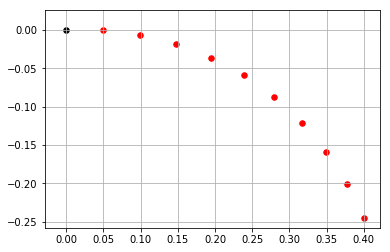

 -- x_train -- 
[[ 4.99690228e-02  1.37036484e-07 -1.75372407e+00]
 [ 9.95669579e-02 -6.07835640e-03 -1.87567407e+00]
 [ 1.48057108e-01 -1.81451941e-02 -1.99762407e+00]
 [ 1.94719231e-01 -3.60211428e-02 -2.11957407e+00]
 [ 2.38860236e-01 -5.94406842e-02 -2.24152407e+00]
 [ 2.79824480e-01 -8.80559589e-02 -2.36347407e+00]
 [ 3.17003506e-01 -1.21441933e-01 -2.48542407e+00]
 [ 3.49845079e-01 -1.59102713e-01 -2.60737407e+00]
 [ 3.77861391e-01 -2.00478908e-01 -2.72932407e+00]
 [ 4.00636305e-01 -2.44955942e-01 -2.85127407e+00]]


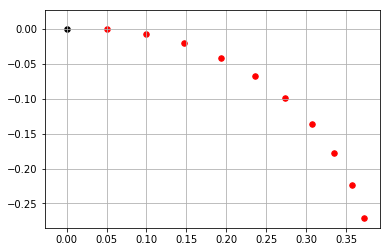

 -- x_train -- 
[[ 4.99594328e-02  2.00706770e-08 -1.78013673e+00]
 [ 9.94331278e-02 -6.94968716e-03 -1.91969673e+00]
 [ 1.47459049e-01 -2.07139819e-02 -2.05925673e+00]
 [ 1.93103313e-01 -4.10252118e-02 -2.19881673e+00]
 [ 2.35478350e-01 -6.74884169e-02 -2.33837673e+00]
 [ 2.73760158e-01 -9.95890096e-02 -2.47793673e+00]
 [ 3.07204334e-01 -1.36702781e-01 -2.61749673e+00]
 [ 3.35160542e-01 -1.78108039e-01 -2.75705673e+00]
 [ 3.57085162e-01 -2.22999641e-01 -2.89661673e+00]
 [ 3.72551861e-01 -2.70504653e-01 -3.03617673e+00]]


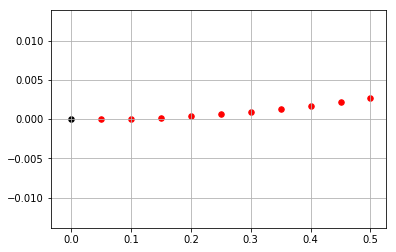

 -- x_train -- 
[[ 4.99999969e-02 -5.47389265e-08 -1.56898023e+00]
 [ 9.99999574e-02  6.03905037e-05 -1.56777023e+00]
 [ 1.49999808e-01  1.81335639e-04 -1.56656023e+00]
 [ 1.99999476e-01  3.62780491e-04 -1.56535023e+00]
 [ 2.49998887e-01  6.04724793e-04 -1.56414023e+00]
 [ 2.99997970e-01  9.07168192e-04 -1.56293023e+00]
 [ 3.49996649e-01  1.27011024e-03 -1.56172023e+00]
 [ 3.99994853e-01  1.69355042e-03 -1.56051023e+00]
 [ 4.49992508e-01  2.17748809e-03 -1.55930023e+00]
 [ 4.99989541e-01  2.72192256e-03 -1.55809023e+00]]


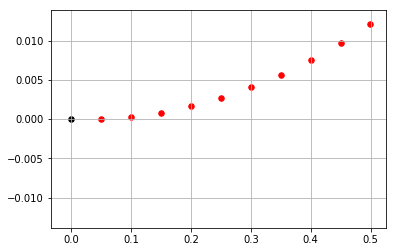

 -- x_train -- 
[[ 4.99999397e-02 -8.46315832e-08 -1.56272463e+00]
 [ 9.99991562e-02  2.68829116e-04 -1.55734463e+00]
 [ 1.49996202e-01  8.06733459e-04 -1.55196463e+00]
 [ 1.99989631e-01  1.61361283e-03 -1.54658463e+00]
 [ 2.49977995e-01  2.68944387e-03 -1.54120463e+00]
 [ 2.99959848e-01  4.03419544e-03 -1.53582463e+00]
 [ 3.49933743e-01  5.64782863e-03 -1.53044463e+00]
 [ 3.99898233e-01  7.53029671e-03 -1.52506463e+00]
 [ 4.49851873e-01  9.68154522e-03 -1.51968463e+00]
 [ 4.99793216e-01  1.21015119e-02 -1.51430463e+00]]


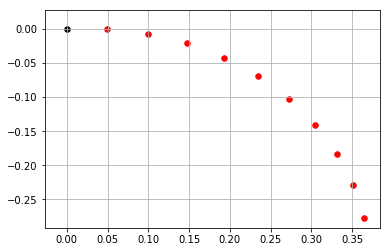

 -- x_train -- 
[[ 4.99566972e-02  1.01281758e-07 -1.78708335e+00]
 [ 9.93949893e-02 -7.17812040e-03 -1.93127335e+00]
 [ 1.47288796e-01 -2.13856828e-02 -2.07546335e+00]
 [ 1.92644094e-01 -4.23277113e-02 -2.21965335e+00]
 [ 2.34519544e-01 -6.95695592e-02 -2.36384335e+00]
 [ 2.72046032e-01 -1.02545828e-01 -2.50803335e+00]
 [ 3.04444703e-01 -1.40572105e-01 -2.65222335e+00]
 [ 3.31043132e-01 -1.82859161e-01 -2.79641335e+00]
 [ 3.51289275e-01 -2.28529341e-01 -2.94060335e+00]
 [ 3.64762927e-01 -2.76634770e-01 -3.08479335e+00]]


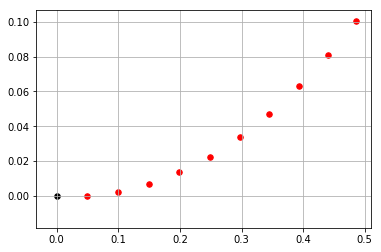

 -- x_train -- 
[[ 4.99957136e-02 -1.07568954e-07 -1.50275418e+00]
 [ 9.99400070e-02  2.26681294e-03 -1.45739418e+00]
 [ 1.49730136e-01  6.79609808e-03 -1.41203418e+00]
 [ 1.99263674e-01  1.35784303e-02 -1.36667418e+00]
 [ 2.48438721e-01  2.25998571e-02 -1.32131418e+00]
 [ 2.97154115e-01  3.38418199e-02 -1.27595418e+00]
 [ 3.45309641e-01  4.72811920e-02 -1.23059418e+00]
 [ 3.92806233e-01  6.28903261e-02 -1.18523418e+00]
 [ 4.39546184e-01  8.06371116e-02 -1.13987418e+00]
 [ 4.85433340e-01  1.00485040e-01 -1.09451418e+00]]


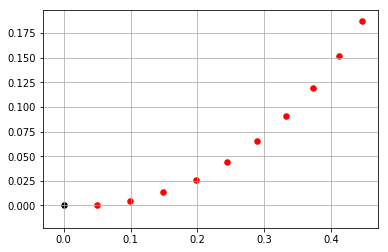

 -- x_train -- 
[[ 4.99837102e-02 -2.43699967e-10 -1.43815132e+00]
 [ 9.97721148e-02  4.41430055e-03 -1.34972132e+00]
 [ 1.48976129e-01  1.32084056e-02 -1.26129132e+00]
 [ 1.97211234e-01  2.63135911e-02 -1.17286132e+00]
 [ 2.44100485e-01  4.36274429e-02 -1.08443132e+00]
 [ 2.89277452e-01  6.50146573e-02 -9.96001322e-01]
 [ 3.32389088e-01  9.03080981e-02 -9.07571322e-01]
 [ 3.73098485e-01  1.19310103e-01 -8.19141322e-01]
 [ 4.11087508e-01  1.51794028e-01 -7.30711322e-01]
 [ 4.46059283e-01  1.87506018e-01 -6.42281322e-01]]


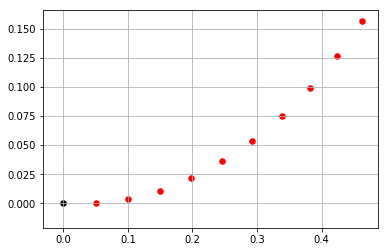

 -- x_train -- 
[[ 4.99890139e-02 -1.62162550e-07 -1.46186308e+00]
 [ 9.98462849e-02  3.62668839e-03 -1.38924308e+00]
 [ 1.49308998e-01  1.08614333e-02 -1.31662308e+00]
 [ 1.98116418e-01  2.16659356e-02 -1.24400308e+00]
 [ 2.46011264e-01  3.59832412e-02 -1.17138308e+00]
 [ 2.92741066e-01  5.37378784e-02 -1.09876308e+00]
 [ 3.38059494e-01  7.48362565e-02 -1.02614308e+00]
 [ 3.81727660e-01  9.91671586e-02 -9.53523083e-01]
 [ 4.23515373e-01  1.26602328e-01 -8.80903083e-01]
 [ 4.63202357e-01  1.56997144e-01 -8.08283083e-01]]


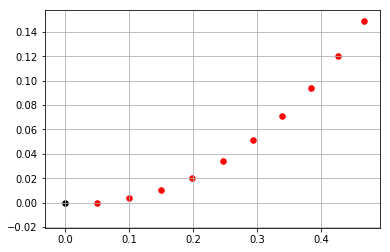

 -- x_train -- 
[[ 4.99901392e-02 -1.83844356e-07 -1.46759265e+00]
 [ 9.98620251e-02  3.43624166e-03 -1.39879265e+00]
 [ 1.49379685e-01  1.02930168e-02 -1.32999265e+00]
 [ 1.98308823e-01  2.05376983e-02 -1.26119265e+00]
 [ 2.46417927e-01  3.41218127e-02 -1.19239265e+00]
 [ 2.93479365e-01  5.09810856e-02 -1.12359265e+00]
 [ 3.39270462e-01  7.10357464e-02 -1.05479265e+00]
 [ 3.83574555e-01  9.41909047e-02 -9.85992649e-01]
 [ 4.26182016e-01  1.20337000e-01 -9.17192649e-01]
 [ 4.66891244e-01  1.49350321e-01 -8.48392649e-01]]


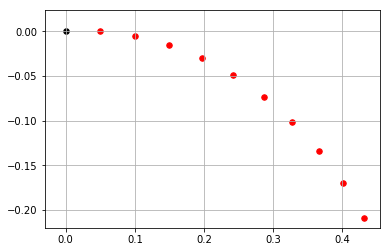

 -- x_train -- 
[[ 4.99792151e-02  1.07442615e-07 -1.72063348e+00]
 [ 9.97093015e-02 -4.98391117e-03 -1.82052348e+00]
 [ 1.48694464e-01 -1.49023666e-02 -1.92041348e+00]
 [ 1.96446335e-01 -2.96563746e-02 -2.02030348e+00]
 [ 2.42488842e-01 -4.90988419e-02 -2.12019348e+00]
 [ 2.86362953e-01 -7.30359326e-02 -2.22008348e+00]
 [ 3.27631256e-01 -1.01229001e-01 -2.31997348e+00]
 [ 3.65882318e-01 -1.33396969e-01 -2.41986348e+00]
 [ 4.00734787e-01 -1.69219132e-01 -2.51975348e+00]
 [ 4.31841193e-01 -2.08338353e-01 -2.61964348e+00]]


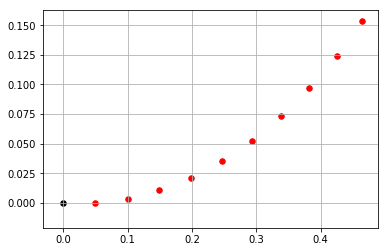

 -- x_train -- 
[[ 4.99894867e-02 -1.94464593e-07 -1.46423244e+00]
 [ 9.98528998e-02  3.54787845e-03 -1.39319244e+00]
 [ 1.49338700e-01  1.06263203e-02 -1.32215244e+00]
 [ 1.98197254e-01  2.11994234e-02 -1.25111244e+00]
 [ 2.46182091e-01  3.52138511e-02 -1.18007244e+00]
 [ 2.93051149e-01  5.25989069e-02 -1.10903244e+00]
 [ 3.38567995e-01  7.32668908e-02 -1.03799244e+00]
 [ 3.82503015e-01  9.71135418e-02 -9.66952437e-01]
 [ 4.24634578e-01  1.24018564e-01 -8.95912437e-01]
 [ 4.64750147e-01  1.53846234e-01 -8.24872437e-01]]


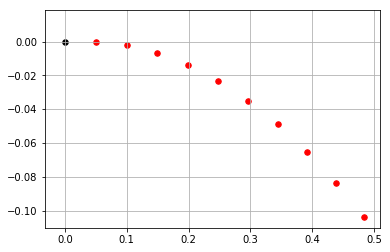

 -- x_train -- 
[[ 4.99953961e-02  7.71742101e-08 -1.64131287e+00]
 [ 9.99355626e-02 -2.34926374e-03 -1.68832287e+00]
 [ 1.49710155e-01 -7.04283179e-03 -1.73533287e+00]
 [ 1.99209195e-01 -1.40702564e-02 -1.78234287e+00]
 [ 2.48323312e-01 -2.34160102e-02 -1.82935287e+00]
 [ 2.96943987e-01 -3.50594435e-02 -1.87636287e+00]
 [ 3.44963792e-01 -4.89748297e-02 -1.92337287e+00]
 [ 3.92276625e-01 -6.51314223e-02 -1.97038287e+00]
 [ 4.38777947e-01 -8.34935228e-02 -2.01739287e+00]
 [ 4.84365010e-01 -1.04020559e-01 -2.06440287e+00]]


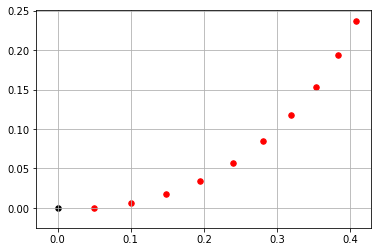

 -- x_train -- 
[[ 4.99714032e-02 -1.14236053e-07 -1.39503904e+00]
 [ 9.96001881e-02  5.84153345e-03 -1.27786904e+00]
 [ 1.48205790e-01  1.74448359e-02 -1.16069904e+00]
 [ 1.95121674e-01  3.46506758e-02 -1.04352904e+00]
 [ 2.39704479e-01  5.72231075e-02 -9.26359041e-01]
 [ 2.81342835e-01  8.48525928e-02 -8.09189041e-01]
 [ 3.19465751e-01  1.17160246e-01 -6.92019041e-01]
 [ 3.53550443e-01  1.53703027e-01 -5.74849041e-01]
 [ 3.83129504e-01  1.93979823e-01 -4.57679041e-01]
 [ 4.07797313e-01  2.37438313e-01 -3.40509041e-01]]


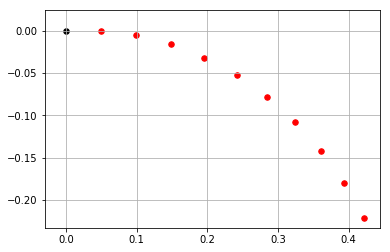

 -- x_train -- 
[[ 4.99760621e-02  2.49853282e-07 -1.73160133e+00]
 [ 9.96652674e-02 -5.34668035e-03 -1.83880133e+00]
 [ 1.48497142e-01 -1.59794034e-02 -1.94600133e+00]
 [ 1.95911055e-01 -3.17758466e-02 -2.05320133e+00]
 [ 2.41362655e-01 -5.25546537e-02 -2.16040133e+00]
 [ 2.84330120e-01 -7.80772664e-02 -2.26760133e+00]
 [ 3.24320147e-01 -1.08050664e-01 -2.37480133e+00]
 [ 3.60873616e-01 -1.42130726e-01 -2.48200133e+00]
 [ 3.93570864e-01 -1.79926186e-01 -2.58920133e+00]
 [ 4.22036499e-01 -2.21003119e-01 -2.69640133e+00]]


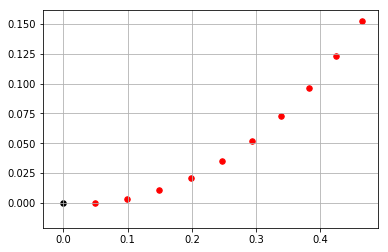

 -- x_train -- 
[[ 4.99896342e-02 -2.12703514e-07 -1.46498207e+00]
 [ 9.98549635e-02  3.52292026e-03 -1.39444207e+00]
 [ 1.49347966e-01  1.05518754e-02 -1.32390207e+00]
 [ 1.98222473e-01  2.10516920e-02 -1.25336207e+00]
 [ 2.46235389e-01  3.49701456e-02 -1.18282207e+00]
 [ 2.93147908e-01  5.22380084e-02 -1.11228207e+00]
 [ 3.38726695e-01  7.27693928e-02 -1.04174207e+00]
 [ 3.82745048e-01  9.64621794e-02 -9.71202072e-01]
 [ 4.24984027e-01  1.23198524e-01 -9.00662072e-01]
 [ 4.65233544e-01  1.52845445e-01 -8.30122072e-01]]


In [7]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    #plt.xlim([-.2,.2])
    #plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [11]:
# loss
def error_squares(z_oplus,z_true):
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance - stage cost
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS-1):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    # distance - terminal cost
    e_distance = e_distance + 10 * error_squares(z_oplus[-1],z_true[-1])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = e_diff_v + error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_diff_v) + '\t'
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = e_diff_w + error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_diff_w) + '\t'
    '''    
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [9]:
# training
def train(model,opt,X,epoch=10,clipping=0):
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            # forward
            x = xp.ravel(X[itr][:,0:2])
            x = Variable(xp.array([x],dtype=xp.float32))
            y_v, y_w = model(x)
            # clip
            if clipping:
                v_limit = DATA_MAX_V_STEP
                w_limit = DATA_MAX_W_STEP
                v = F.clip(y_v,0.0,v_limit)
                w = F.clip(y_w,-w_limit,w_limit)
            else:
                v = y_v
                w = y_w
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
            y_pad = F.stack((v,pad,w),axis=2)
            
            # loss
            loss = loss_function(y_pad, X[itr][:])
            
            # update
            model.cleargrads()
            loss.backward()
            opt.update()
            #y_grad = chainer.grad( (e,), (y,) )[0]
            #print(y_grad)
            #x_grad = chainer.grad( (e,), (x,) )[0]
            #print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    return model, AvgLoss

In [10]:
EPOCH = 10
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
if settings.gpu_index >= 0:
    cuda.cupy.cuda.Device(settings.gpu_index).use()
    model.to_gpu(settings.gpu_index)
opt = optimizers.Adam()
opt.setup(model)
model,loss_avg = train(model,opt,X_train,epoch=EPOCH,clipping=0)
model,loss_avg_clip = train(model,opt,X_train,epoch=EPOCH,clipping=1)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

Epoch: 1 , Average loss: 0.92996097
Epoch: 2 , Average loss: 0.2752565
Epoch: 3 , Average loss: 0.22001445
Epoch: 4 , Average loss: 0.18795161
Epoch: 5 , Average loss: 0.16787203
Epoch: 6 , Average loss: 0.15261662
Epoch: 7 , Average loss: 0.14690885
Epoch: 8 , Average loss: 0.13391957
Epoch: 9 , Average loss: 0.11816347
Epoch: 10 , Average loss: 0.11224605
Epoch: 1 , Average loss: 0.16872814
Epoch: 2 , Average loss: 0.14053668
Epoch: 3 , Average loss: 0.12984537
Epoch: 4 , Average loss: 0.11819085
Epoch: 5 , Average loss: 0.11566695
Epoch: 6 , Average loss: 0.116165705
Epoch: 7 , Average loss: 0.105623275
Epoch: 8 , Average loss: 0.11658844
Epoch: 9 , Average loss: 0.10882002
Epoch: 10 , Average loss: 0.10805269
start: 2019/11/05 17:38:00
finish: 2019/11/05 17:47:28


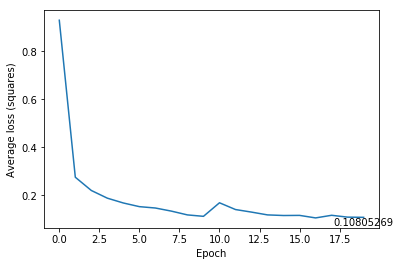

In [11]:
def plot_average_loss(loss_avg):
    fig = plt.figure()
    plt.plot(range(len(loss_avg)),loss_avg)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(loss_avg)-1, loss_avg[-1],str(loss_avg[-1]),ha='center',va='top' )
    return fig
loss_avg.extend(loss_avg_clip)
fig = plot_average_loss(loss_avg)

In [12]:
# log
def gen_filename(header):
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_V_STEP * 1000))
    fn = header + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename('Clip1_')
os.mkdir(dirname)
print(dirname)

Clip1_50mm10step_201911051747_1000data10ep


In [13]:
f = open(dirname+'/params.txt','w')
for l in params:
    f.write(l+'\n')
f.close()
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 4.99624101e-02 -1.03614285e-07 -1.36928425e+00]
 [ 9.94746700e-02  6.69157339e-03 -1.23494425e+00]
 [ 1.47644563e-01  1.99544463e-02 -1.10060425e+00]
 [ 1.93604063e-01  3.95495166e-02 -9.66264253e-01]
 [ 2.36524975e-01  6.51236790e-02 -8.31924253e-01]
 [ 2.75633858e-01  9.62160843e-02 -6.97584253e-01]
 [ 3.10225967e-01  1.32266444e-01 -5.63244253e-01]
 [ 3.39677947e-01  1.72625126e-01 -4.28904253e-01]
 [ 3.63459072e-01  2.16564864e-01 -2.94564253e-01]
 [ 3.81140802e-01  2.63293858e-01 -1.60224253e-01]]
 --- output --- 
[[[ 0.04889922  0.          0.156032  ]
  [ 0.04490607  0.          0.15543553]
  [ 0.05662246  0.          0.15707964]
  [ 0.04239066  0.          0.15707964]
  [ 0.05517418  0.          0.15707964]
  [ 0.06411803  0.         -0.15707964]
  [ 0.02360982  0.          0.15707964]
  [ 0.0335111   0.          0.15707964]
  [ 0.06328683  0.          0.15707964]
  [ 0.05430874  0.          0.15707964]]]
 --- error --- 
e_distance: variable(0.166228)	
loss: 

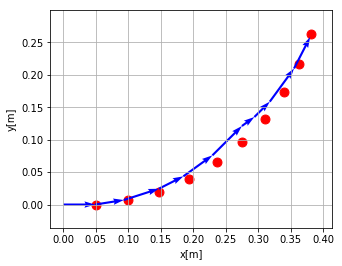

 --- grad --- 
variable([[ -7.8963513  -7.993077   -7.955801   -9.063374   -9.253164
           -10.0520525  -9.879686  -10.155595   -9.952791   -9.556292 ]])
variable([[-2.0724053 -1.7835426  0.         0.         0.
            0.         0.         0.         0.         0.       ]])


In [14]:
rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
d = data.rotate_path(d,rand_rad*0.5)
if DATA_RANGE_TRANSLATE != 0:
    rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
    d = data.translate_path(d,rand_trans_x,0.0)
if DATA_RANGE_ROTATE != 0:
    rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
    d = data.rotate_path(d,rand_rotate)
x_test = d
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''
x = xp.ravel(x_test[:,0:2])
x = xp.array([x],dtype=xp.float32)
y_v,y_w = model(x)
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,0.0,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
# loss
print(' --- error --- ')
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
z_true = x_test
z = y_pad[0,0]
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
#print(' --- trajectory --- ')
#print(Z)
#print(z_true.shape)
fig = plot_path(Z,z_true)
print(' --- grad --- ')
v_grad = chainer.grad( (loss,), (y_v,) )[0]
print(v_grad)
w_grad = chainer.grad( (loss,), (y_w,) )[0]
print(w_grad)
#x_grad = chainer.grad( (loss,), (x,) )[0]
#print(x_grad)

 --- input --- 
[[ 4.99727153e-02  2.27792923e-07 -1.74247589e+00]
 [ 9.96185223e-02 -5.70644518e-03 -1.85692589e+00]
 [ 1.48287830e-01 -1.70453499e-02 -1.97137589e+00]
 [ 1.95343824e-01 -3.38681223e-02 -2.08582589e+00]
 [ 2.40170801e-01 -5.59546448e-02 -2.20027589e+00]
 [ 2.82182220e-01 -8.30159258e-02 -2.31472589e+00]
 [ 3.20828383e-01 -1.14697882e-01 -2.42917589e+00]
 [ 3.55603624e-01 -1.50585970e-01 -2.54362589e+00]
 [ 3.86052926e-01 -1.90210612e-01 -2.65807589e+00]
 [ 4.11777875e-01 -2.33053340e-01 -2.77252589e+00]]
 --- output --- 
[[[ 0.05053902  0.         -0.12497369]
  [ 0.04960702  0.         -0.07119277]
  [ 0.05156714  0.         -0.15272155]
  [ 0.05140893  0.         -0.15481333]
  [ 0.04911985  0.         -0.06921241]
  [ 0.04999127  0.         -0.10569936]
  [ 0.04906823  0.         -0.1522601 ]
  [ 0.05218445  0.         -0.06275363]
  [ 0.04717356  0.         -0.15117697]
  [ 0.04943033  0.          0.00433958]]]
 --- error --- 
loss: variable(0.0005663)
loss: variab

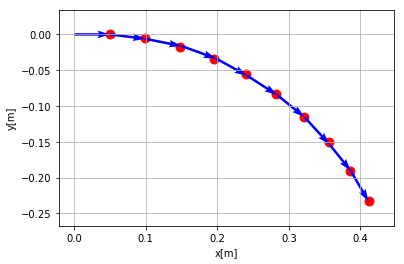

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99964826e-02 -1.44208977e-07 -1.50915844e+00]
 [ 9.99507703e-02  2.05348913e-03 -1.46806844e+00]
 [ 1.49778533e-01  6.15743318e-03 -1.42697844e+00]
 [ 1.99395653e-01  1.23047599e-02 -1.38588844e+00]
 [ 2.48718371e-01  2.04850916e-02 -1.34479844e+00]
 [ 2.97663421e-01  3.06846186e-02 -1.30370844e+00]
 [ 3.46148177e-01  4.28861228e-02 -1.26261844e+00]
 [ 3.94090789e-01  5.70690060e-02 -1.22152844e+00]
 [ 4.41410324e-01  7.32093254e-02 -1.18043844e+00]
 [ 4.88026898e-01  9.12798338e-02 -1.13934844e+00]]
 --- output --- 
[[[ 0.05068088  0.          0.03897402]
  [ 0.05101488  0.          0.05749752]
  [ 0.0478722   0.          0.03106177]
  [ 0.05052259  0.          0.03127697]
  [ 0.0479469   0.          0.15707964]
  [ 0.05115026  0.         -0.15707964]
  [ 0.04931008  0.          0.12655343]
  [ 0.04955962  0.          0.07505649]
  [ 0.04811817  0.          0.04754956]

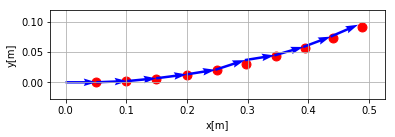

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99876264e-02  2.35819341e-07 -1.68640604e+00]
 [ 9.98268865e-02 -3.84826268e-03 -1.76347604e+00]
 [ 1.49221892e-01 -1.15226475e-02 -1.84054604e+00]
 [ 1.97879394e-01 -2.29773571e-02 -1.91761604e+00]
 [ 2.45510518e-01 -3.81443866e-02 -1.99468604e+00]
 [ 2.91832487e-01 -5.69336917e-02 -2.07175604e+00]
 [ 3.36570294e-01 -7.92337232e-02 -2.14882604e+00]
 [ 3.79458338e-01 -1.04912089e-01 -2.22589604e+00]
 [ 4.20241999e-01 -1.33816341e-01 -2.30296604e+00]
 [ 4.58679150e-01 -1.65774879e-01 -2.38003604e+00]]
 --- output --- 
[[[ 0.05080204  0.         -0.08713581]
  [ 0.05080387  0.         -0.04212266]
  [ 0.0493149   0.         -0.11031173]
  [ 0.05211777  0.         -0.11212661]
  [ 0.0478612   0.         -0.00807587]
  [ 0.04877724  0.         -0.1203592 ]
  [ 0.0522809   0.         -0.08838821]
  [ 0.05330203  0.         -0.03045075]
  [ 0.04562169  0.         -0.10449393]

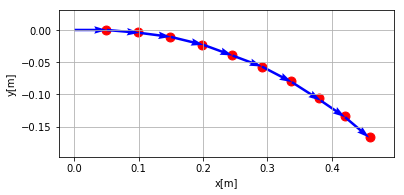

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99505165e-02 -4.40789814e-08 -1.33958544e+00]
 [ 9.93088230e-02  7.66883276e-03 -1.18544544e+00]
 [ 1.46904529e-01  2.28247851e-02 -1.03130544e+00]
 [ 1.91609038e-01  4.51084329e-02 -8.77165444e-01]
 [ 2.32362311e-01  7.39913833e-02 -7.23025444e-01]
 [ 2.68198001e-01  1.08788760e-01 -5.68885444e-01]
 [ 2.98266367e-01  1.48675443e-01 -4.14745444e-01]
 [ 3.21854425e-01  1.92705633e-01 -2.60605444e-01]
 [ 3.38402849e-01  2.39835281e-01 -1.06465444e-01]
 [ 3.47519244e-01  2.88946842e-01  4.76745557e-02]]
 --- output --- 
[[[ 0.04764284  0.          0.15707964]
  [ 0.04023879  0.          0.15707964]
  [ 0.06394904  0.          0.15707964]
  [ 0.03724981  0.          0.15707964]
  [ 0.06049807  0.          0.15707964]
  [ 0.0723996   0.         -0.15707964]
  [ 0.00617008  0.          0.15707964]
  [ 0.02370289  0.          0.15707964]
  [ 0.07313116  0.          0.15707964]

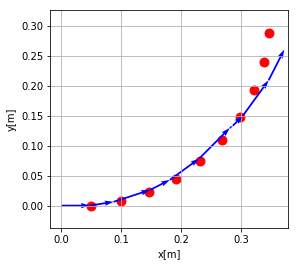

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99691091e-02  1.31128689e-07 -1.75346895e+00]
 [ 9.95681617e-02 -6.06994692e-03 -1.87524895e+00]
 [ 1.48062494e-01 -1.81203238e-02 -1.99702895e+00]
 [ 1.94733806e-01 -3.59725089e-02 -2.11880895e+00]
 [ 2.38890800e-01 -5.93620746e-02 -2.24058895e+00]
 [ 2.79879419e-01 -8.79425736e-02 -2.36236895e+00]
 [ 3.17092540e-01 -1.21290670e-01 -2.48414895e+00]
 [ 3.49978958e-01 -1.58912410e-01 -2.60592895e+00]
 [ 3.78051560e-01 -2.00250540e-01 -2.72770895e+00]
 [ 4.00894531e-01 -2.44692755e-01 -2.84948895e+00]]
 --- output --- 
[[[ 0.05059171  0.         -0.13098198]
  [ 0.04977384  0.         -0.0761481 ]
  [ 0.05135326  0.         -0.15707964]
  [ 0.0516723   0.         -0.15707964]
  [ 0.048915    0.         -0.07864556]
  [ 0.04957455  0.         -0.10309575]
  [ 0.04985453  0.         -0.15707964]
  [ 0.05271708  0.         -0.0677821 ]
  [ 0.04669226  0.         -0.15707964]

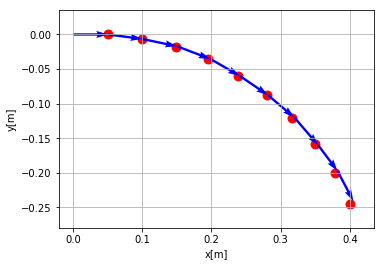

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99861461e-02  1.37859959e-07 -1.69312408e+00]
 [ 9.98061816e-02 -4.07157821e-03 -1.77467408e+00]
 [ 1.49128967e-01 -1.21880847e-02 -1.85622408e+00]
 [ 1.97626667e-01 -2.42954334e-02 -1.93777408e+00]
 [ 2.44976931e-01 -4.03131502e-02 -2.01932408e+00]
 [ 2.90865037e-01 -6.01347699e-02 -2.10087408e+00]
 [ 3.34985977e-01 -8.36285438e-02 -2.18242408e+00]
 [ 3.77046494e-01 -1.10638315e-01 -2.26397408e+00]
 [ 4.16767022e-01 -1.40984558e-01 -2.34552408e+00]
 [ 4.53883550e-01 -1.74465570e-01 -2.42707408e+00]]
 --- output --- 
[[[ 0.05077681  0.         -0.09178296]
  [ 0.0506837   0.         -0.04570974]
  [ 0.04954842  0.         -0.115523  ]
  [ 0.05205872  0.         -0.11737975]
  [ 0.04798541  0.         -0.01555016]
  [ 0.04888094  0.         -0.11854848]
  [ 0.05198327  0.         -0.09626894]
  [ 0.05321755  0.         -0.03440082]
  [ 0.04575801  0.         -0.11020755]

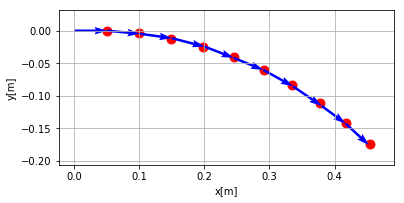

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99999992e-02 -1.95797243e-07 -1.56987741e+00]
 [ 9.99999893e-02  3.01084032e-05 -1.56926741e+00]
 [ 1.49999952e-01  9.09125900e-05 -1.56865741e+00]
 [ 1.99999867e-01  1.82216741e-04 -1.56804741e+00]
 [ 2.49999718e-01  3.04020821e-04 -1.56743741e+00]
 [ 2.99999486e-01  4.56324786e-04 -1.56682741e+00]
 [ 3.49999151e-01  6.39128579e-04 -1.56621741e+00]
 [ 3.99998695e-01  8.52432131e-04 -1.56560741e+00]
 [ 4.49998100e-01  1.09623536e-03 -1.56499741e+00]
 [ 4.99997346e-01  1.37053819e-03 -1.56438741e+00]]
 --- output --- 
[[[ 0.05082646  0.         -0.00495324]
  [ 0.05133243  0.          0.02251899]
  [ 0.0477474   0.         -0.01818948]
  [ 0.05148885  0.         -0.01879736]
  [ 0.04747373  0.          0.12152912]
  [ 0.04965794  0.         -0.15320349]
  [ 0.05176271  0.          0.0519207 ]
  [ 0.05163842  0.          0.03855717]
  [ 0.04645341  0.         -0.0049998 ]

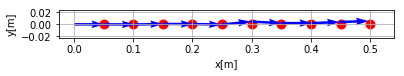

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99995510e-02 -1.26555627e-07 -1.54877380e+00]
 [ 9.99937165e-02  7.33713949e-04 -1.53409380e+00]
 [ 1.49971723e-01  2.20136337e-03 -1.51941380e+00]
 [ 1.99922800e-01  4.40250544e-03 -1.50473380e+00]
 [ 2.49836183e-01  7.33666580e-03 -1.49005380e+00]
 [ 2.99701116e-01  1.10032122e-02 -1.47537380e+00]
 [ 3.49506853e-01  1.54013544e-02 -1.46069380e+00]
 [ 3.99242661e-01  2.05301447e-02 -1.44601380e+00]
 [ 4.48897822e-01  2.63884777e-02 -1.43133380e+00]
 [ 4.98461636e-01  3.29750912e-02 -1.41665380e+00]]
 --- output --- 
[[[ 0.05072755  0.          0.00970636]
  [ 0.05103619  0.          0.03437156]
  [ 0.04809406  0.         -0.00179179]
  [ 0.05096627  0.         -0.0020719 ]
  [ 0.04784739  0.          0.14397375]
  [ 0.05048046  0.         -0.15707964]
  [ 0.05025374  0.          0.07701528]
  [ 0.05056679  0.          0.0506868 ]
  [ 0.04739649  0.          0.01232508]

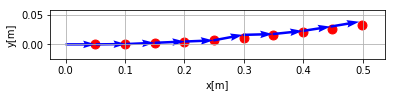

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99876713e-02  2.14559841e-07 -1.68619562e+00]
 [ 9.98275128e-02 -3.84133105e-03 -1.76312562e+00]
 [ 1.49224707e-01 -1.15019129e-02 -1.84005562e+00]
 [ 1.97887053e-01 -2.29362163e-02 -1.91698562e+00]
 [ 2.45526700e-01 -3.80766039e-02 -1.99391562e+00]
 [ 2.91861844e-01 -5.68335155e-02 -2.07084562e+00]
 [ 3.36618398e-01 -7.90959984e-02 -2.14777562e+00]
 [ 3.79531614e-01 -1.04732363e-01 -2.22470562e+00]
 [ 4.20347646e-01 -1.33590963e-01 -2.30163562e+00]
 [ 4.58825056e-01 -1.65501090e-01 -2.37856562e+00]]
 --- output --- 
[[[ 0.05080281  0.         -0.0869904 ]
  [ 0.05080752  0.         -0.04201036]
  [ 0.04930776  0.         -0.11014867]
  [ 0.05211952  0.         -0.11196218]
  [ 0.04785743  0.         -0.00784216]
  [ 0.04877418  0.         -0.1204159 ]
  [ 0.05228984  0.         -0.08814149]
  [ 0.05330447  0.         -0.03032722]
  [ 0.04561763  0.         -0.10431523]

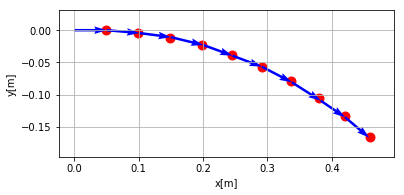

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99754283e-02  1.67852157e-07 -1.73371469e+00]
 [ 9.96564061e-02 -5.41683161e-03 -1.84232469e+00]
 [ 1.48457466e-01 -1.61871615e-02 -1.95093469e+00]
 [ 1.95803509e-01 -3.21838986e-02 -2.05954469e+00]
 [ 2.41136586e-01 -5.32185284e-02 -2.16815469e+00]
 [ 2.83922465e-01 -7.90431677e-02 -2.27676469e+00]
 [ 3.23656935e-01 -1.09353485e-01 -2.38537469e+00]
 [ 3.59871743e-01 -1.43792287e-01 -2.49398469e+00]
 [ 3.92140115e-01 -1.81953728e-01 -2.60259469e+00]
 [ 4.20081783e-01 -2.23388093e-01 -2.71120469e+00]]
 --- output --- 
[[[ 0.05058692  0.         -0.11922261]
  [ 0.04981901  0.         -0.06679184]
  [ 0.05117649  0.         -0.14627957]
  [ 0.05154801  0.         -0.14833808]
  [ 0.04889451  0.         -0.05988509]
  [ 0.04975591  0.         -0.10791738]
  [ 0.04966515  0.         -0.14259945]
  [ 0.05241338  0.         -0.05782339]
  [ 0.04687693  0.         -0.14406145]

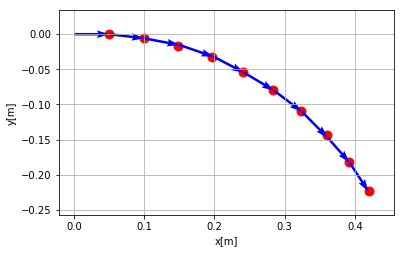

 ---------------------------------------------------------------------------------------------- 


In [15]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    
    x_test = d
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    y_v,y_w = model(x)
    # clip
    v_limit = DATA_MAX_V_STEP
    w_limit = DATA_MAX_W_STEP
    v = F.clip(y_v,0.0,v_limit)
    w = F.clip(y_w,-w_limit,w_limit)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
    y_pad = F.stack((v,pad,w),axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    #print(' --- trajectory --- ')
    #print(Z)
    #print(z_true.shape)
    fig = plot_path(Z,z_true)
    fig.savefig(dirname + '/test' + str(i) + '.png')
    print(' ---------------------------------------------------------------------------------------------- ')

 --- input --- 
[[ 0.04362432 -0.01988486]
 [ 0.0504621  -0.06733729]
 [ 0.01422674 -0.09872974]
 [-0.03176716 -0.08520015]
 [-0.04523301 -0.03918755]
 [-0.01379037 -0.00299572]
 [ 0.03365254 -0.00989925]
 [ 0.05347693 -0.05355108]
 [ 0.02745634 -0.09381791]
 [-0.02048601 -0.09367861]]
v
variable([[0.05098518 0.05301605 0.04617335 0.05058391 0.04857601
           0.04970181 0.05061447 0.0512807  0.05293243 0.04999607]])
w
variable([[-0.0903318  -0.09855502 -0.08380567 -0.08425293 -0.15707964
           -0.0578969  -0.1067691  -0.14234726 -0.06991683 -0.10047609]])
 --- output --- 
[[[ 0.05098518  0.         -0.0903318 ]
  [ 0.05301605  0.         -0.09855502]
  [ 0.04617335  0.         -0.08380567]
  [ 0.05058391  0.         -0.08425293]
  [ 0.04857601  0.         -0.15707964]
  [ 0.04970181  0.         -0.0578969 ]
  [ 0.05061447  0.         -0.1067691 ]
  [ 0.0512807   0.         -0.14234726]
  [ 0.05293243  0.         -0.06991683]
  [ 0.04999607  0.         -0.10047609]]]


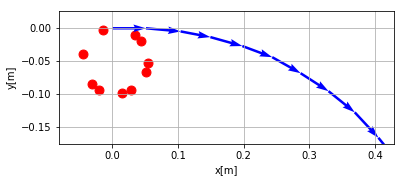

In [13]:
'''
x = xp.array([ 0.04362432, -0.01988486,  0.0504621,  -0.06733729,  0.01422674,
           -0.09872974, -0.03176716, -0.08520015, -0.04523301, -0.03918755,
           -0.01379037, -0.00299572,  0.03365254, -0.00989925,  0.05347693,
           -0.05355108,  0.02745634, -0.09381791, -0.02048601, -0.09367861],dtype=xp.float32)
x_test = xp.reshape(x,(10,2))
y_v =xp.array([[ 0.05098518,  0.05301605,  0.04617335,  0.05058391,  0.04857601,  0.04970181,
   0.05061447,  0.0512807,   0.05293243,  0.04999607]],dtype=xp.float32)
y_w =xp.array([[-0.0903318,  -0.09855502, -0.08380567, -0.08425293, -0.23067333, -0.0578969,
  -0.1067691,  -0.14234726, -0.06991683, -0.10047609]],dtype=xp.float32)
 
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,0.0,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print('v')
print(v)
print('w')
print(w)
print(' --- output --- ')
print(y_pad.data)
z_true = x_test
z = y_pad[0,0]
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
#print(' --- trajectory --- ')
#print(Z)
#print(z_true.shape)
fig = plot_path(Z,z_true)
'''